# Face and Facial Keypoint detection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import toolz
import sys
sys.path.append('..')
%matplotlib inline
%load_ext autoreload
%autoreload 2
from keypoint_detection.transformation import ToGrayscale, Rescale
from keypoint_detection.dataset import image_ndarray_to_tensor, keypoints_tensor_to_ndarray
from keypoint_detection import visualization as vis

#### Select an image 

Select an image to perform facial keypoint detection on; you can select any image of faces in the `images/` directory.

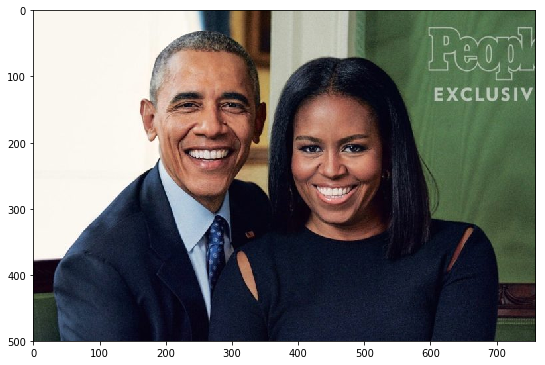

In [2]:
import cv2
# load in color image for face detection
image = cv2.imread('images/obamas.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

## Detect all faces in an image

Next, you'll use one of OpenCV's pre-trained Haar Cascade classifiers, all of which can be found in the `detector_architectures/` directory, to find any faces in your selected image.

In the code below, we loop over each face in the original image and draw a red square on each face (in a copy of the original image, so as not to modify the original). You can even [add eye detections](https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html) as an *optional* exercise in using Haar detectors.

An example of face detection on a variety of images is shown below.

<img src='images/haar_cascade_ex.png' width=80% height=80%/>


In [3]:
import cv2
# load in a haar cascade classifier for detecting frontal faces

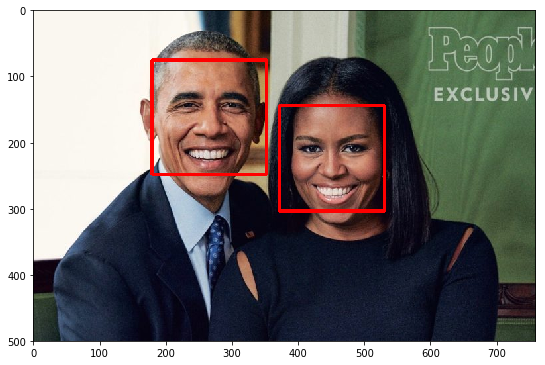

In [4]:
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.2, 2)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

In [5]:
import torch
from keypoint_detection.network import KeypointDetector96
net = KeypointDetector96()

In [6]:
net = net.cpu()

In [8]:
with open('saved_models/keypoints_model_1.pt', 'rb') as f:
    state_dict = torch.load(f)
net.load_state_dict(state_dict)

## print out your net and prepare it for testing (uncomment the line below)
net.eval()

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (4): Flatten()
  (5): Linear(in_features=9216, out_features=4096, bias=True)
  (6): ReLU()
  (7): Linear(in_features=4096, out_features=1024, bias=True)
  (8): ReLU

## Keypoint detection

Now, we'll loop over each detected face in an image (again!) only this time, you'll transform those faces in Tensors that your CNN can accept as input images.

### TODO: Transform each detected face into an input Tensor

You'll need to perform the following steps for each detected face:
1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
3. Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
4. Reshape the numpy image into a torch image.

You may find it useful to consult to transformation code in `data_load.py` to help you perform these processing steps.


### TODO: Detect and display the predicted keypoints

After each face has been appropriately converted into an input Tensor for your network to see as input, you'll wrap that Tensor in a Variable() and can apply your `net` to each face. The ouput should be the predicted the facial keypoints. These keypoints will need to be "un-normalized" for display, and you may find it helpful to write a helper function like `show_keypoints`. You should end up with an image like the following with facial keypoints that closely match the facial features on each individual face:

<img src='images/michelle_detected.png' width=30% height=30%/>




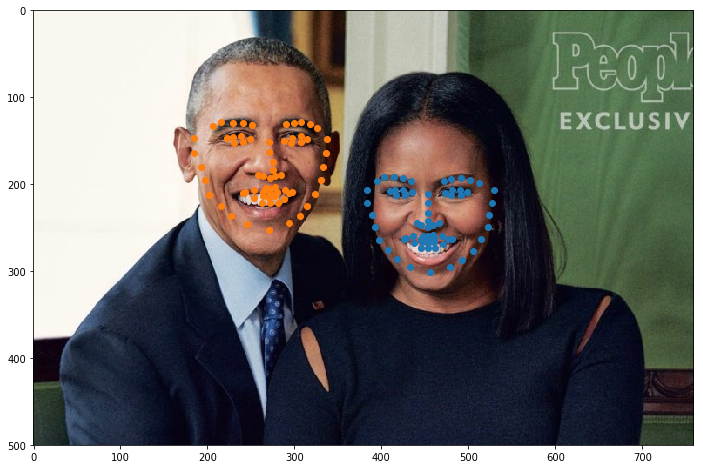

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(image)
# boxes are too small
margin = .2

for (x,y,w,h) in faces:
    
    xmin = max(0, int(x - margin * w))
    xmax = min(image.shape[1] - 1, int(x + w * (1 + margin)))
    ymin = max(0, int(y - margin * h))
    ymax = min(image.shape[0] - 1, int(y + h * (1 + margin)))
    roi = image[ymin : ymax, xmin : xmax]
    
    
    face_image_tensor = toolz.pipe(
        roi,
        image_ndarray_to_tensor,
        ToGrayscale,
        Rescale(target_width=96, target_height=96),
    )
    with torch.no_grad():
        normalized_keypoints_tensor = net(face_image_tensor)
    keypoint_relative_coordinates = keypoints_tensor_to_ndarray(normalized_keypoints_tensor, ymax - ymin, xmax - xmin)[0]
    relative_x = keypoint_relative_coordinates[0::2]
    relative_y = keypoint_relative_coordinates[1::2]
    ax.scatter(relative_x + xmin, relative_y + ymin)
    